In [8]:
import os, sys
import gensim
import gensim.downloader as api

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re



import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


/device:GPU:0
Num GPUs Available:  1


In [2]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 300#100

In [3]:
df=pd.read_csv('aty.csv', index_col=0)
df

,Id,QA,Atypical_Annot,Aty,method,obj1,obj2,Atypical_Annot2
0,110991.jpg,I should eat Oreos because I can snack on Oreo...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
1,110991.jpg,I should eat Oreos because I can snack on Oreo...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
2,110991.jpg,I should eat Oreos because I can snack on Oreo...,Object Replacement: The object which is placed...,cookie milk person body hoopnet,Object Replacement,cookie- milk,person- body- hoop/net,Object Replacement: The object which is placed...
3,110991.jpg,I should eat Oreo's because Oreo fun to dunk O...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
4,110991.jpg,I should eat Oreo's because Oreo fun to dunk O...,Liquid Deformed Object: The liquid which has b...,milk,Liquid Deformed Object,milk,NaN,Liquid Deformed Object: The liquid which has b...
...,...,...,...,...,...,...,...,...
14202,102221.jpg,I should buy Oreo cookies because Oreo cookies...,Object Replacement: The object which is placed...,oreo persons head,Object Replacement,oreo,person's head,Object Replacement: The object which is placed...
14203,102221.jpg,I should buy oreo cookies because when you eat...,Object with Missing Part: The objects which ha...,person,Object with Missing Part,person,NaN,Object with Missing Part: The objects which ha...
14204,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,a persons body tornado,Solid Deformed Object,a persons body,tornado,Solid Deformed Object: The objects that have b...
14205,102221.jpg,I should buy oreo cookies because when you eat...,Solid Deformed Object: The objects that have b...,person twisted,Solid Deformed Object,person,twisted,Solid Deformed Object: The objects that have b...


In [4]:
def preprocess(sentences, prefix, postfix):
    try:

        sentences = [row for row in (sentences)]
        sentences = [sen.replace('<b>','') for sen in sentences]
        sentences = [sen.replace('</b>','') for sen in sentences]
        sentences = [re.sub(r'[^\w\s]',' ',sen) for sen in sentences]
        sentences = [re.sub(r'\d+',' ',sen) for sen in sentences]
        sentences = [re.sub(' +', ' ',sen) for sen in sentences]
        sentences = [prefix + sen + postfix for sen in sentences]
    #     sentences = [[word for word in document.lower().split()] for document in sentences]
    #     print(sentences[:1])
    except:
        pass
    return sentences


    

input_sentences = preprocess(df['QA'],prefix='',postfix='')
output_sentences = preprocess(df['Atypical_Annot'],prefix='',postfix=' <eos>')
output_sentences_inputs = preprocess(df['Atypical_Annot'],prefix='<sos> ',postfix='.')

method = preprocess(df['method'].astype("str"),prefix='',postfix='')
obj1 = preprocess(df['obj1'].astype("str"),prefix='',postfix='')
obj2 = preprocess(df['obj2'].astype("str"),prefix='',postfix='')



print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))
print("num samples method, obj1, obj2:", len(method), len(obj1), len(obj2))


num samples input: 14207
num samples output: 14207
num samples output input: 14207
num samples method, obj1, obj2: 14207 14207 14207


In [11]:
obj1

['milk',
 'milk',
 'cookie milk',
 'milk',
 'milk',
 'cookie milk',
 'milk',
 'milk',
 'cookie milk',
 'man and woman',
 'people',
 'man and woman',
 'people',
 'man and woman',
 'people',
 'man and woman',
 'people',
 'man and woman',
 'people',
 'deer',
 'candy reindeer',
 'deer head',
 'deer',
 'candy reindeer',
 'deer head',
 'deer',
 'candy reindeer',
 'deer head',
 'phone',
 'phone',
 'phone',
 'woman s appendages m m',
 'woman s appendages m m',
 'woman s appendages m m',
 'health',
 'health',
 'health',
 'paper',
 'paper',
 'paper',
 'paper',
 'paper',
 'human',
 'human',
 'human',
 'ad',
 'ad',
 'ad',
 'head',
 'head',
 'head',
 'letters',
 'fingers',
 'letters',
 'fingers',
 'letters',
 'fingers',
 'milk',
 'milk',
 'milk',
 'milk',
 'milk',
 'car bridge roads',
 'nan',
 'nan',
 'car bridge roads',
 'nan',
 'nan',
 'car bridge roads',
 'nan',
 'nan',
 'piano',
 'piano',
 'piano',
 'piano',
 'piano',
 'water',
 'water',
 'water',
 'water',
 'water',
 'water',
 'water',
 'water

In [10]:
'''intputs: obj1, obj2,
outputs: Atypical sentence'''




dataset = tf.data.Dataset.from_tensor_slices(({"input_1": obj1, "input_2": obj2},
                                              output_sentences_inputs))
for item in dataset.take(1):
    print(item)

({'input_1': <tf.Tensor: shape=(), dtype=string, numpy=b'milk'>, 'input_2': <tf.Tensor: shape=(), dtype=string, numpy=b'nan'>}, <tf.Tensor: shape=(), dtype=string, numpy=b'<sos> Liquid Deformed Object The liquid which has been deformed is Milk.'>)


In [ ]:
import numpy
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint




In [5]:
#input

# tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# tokenizer.fit_on_texts((input_sentences + output_sentences + output_sentences_inputs + method + obj1 + obj2))
# print('input')
# # input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# # input_tokenizer.fit_on_texts(input_sentences)
# input_integer_seq = tokenizer.texts_to_sequences(input_sentences)

# word2idx_inputs = tokenizer.word_index
# print('Total unique words in the input: %s' % len(word2idx_inputs))

# max_input_len = max(len(sen) for sen in input_integer_seq)
# print("Length of longest sentence in input: %g" % max_input_len)

# #output
# print('output')
# # output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
# # output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
# output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
# output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

# word2idx_outputs = output_tokenizer.word_index
# print('Total unique words in the output: %s' % len(word2idx_outputs))

# num_words_output = len(word2idx_outputs) + 1
# max_out_len = max(len(sen) for sen in output_integer_seq)
# print("Length of longest sentence in the output: %g" % max_out_len)


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts((input_sentences + output_sentences + output_sentences_inputs + method + obj1 + obj2))

input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

method_seq = tokenizer.texts_to_sequences(method)
obj1_seq = tokenizer.texts_to_sequences(obj1)
obj2_seq = tokenizer.texts_to_sequences(obj2)

word2idx_word = tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_word))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)




encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

# print('word2idx_inputs of milk and oreo:')
# print(word2idx_inputs["milk"])
# print(word2idx_inputs["oreo"])

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
method_sequences = pad_sequences(method_seq, maxlen=max_out_len, padding='post')
obj1_sequences = pad_sequences(obj1_seq, maxlen=max_out_len, padding='post')
obj2_sequences = pad_sequences(obj2_seq, maxlen=max_out_len, padding='post')

print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])


#########
# #word embedding:
# embeddings_dictionary = dict()

# glove_file = open(r'/content/drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary[word] = vector_dimensions
# glove_file.close()

Total unique words in the input: 7629
Length of longest sentence in input: 51
Length of longest sentence in the output: 54
encoder_input_sequences.shape: (14207, 51)
encoder_input_sequences[172]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   11   18   32 5015  103 3701   17  935
 3994  377    3   64   16 5016   43 5017  103]
decoder_input_sequences.shape: (14207, 54)
decoder_input_sequences[172]: [  15    1    8    2    1    4    3   26   23    2   27    9   10    1
    3  103    6    2    1    4    3   25   24   10    1   28    1  377
 1590    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [6]:
wv = api.load('word2vec-google-news-300')


In [7]:
# num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
# for word, index in word2idx_inputs.items():
# #     embedding_vector = embeddings_dictionary.get(word)
#     embedding_vector = wv.get_sentence_vector(word)
    
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

# input_tokenizer, input_integer_seq_test

In [7]:

def word2idx(word):
    try:
        return wv.key_to_index[word]    
    except:
        return -1
#         return word_model.key_to_index['OOV']
#         return np.zeros((300,))
    
def idx2word(idx):
    return wv.index_to_key[idx]




# input_sentences = preprocess(df['QA'],prefix='',postfix='.')
# output_sentences = preprocess(df['Atypical_Annot'],prefix='',postfix='. <eos>')
# output_sentences_inputs = preprocess(df['Atypical_Annot'],prefix='<sos> ',postfix='.')


intputdata = input_sentences
senOut = output_sentences
wordOut = output_sentences_inputs


max_sentence_len=54
train_x = np.zeros([len(intputdata), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(intputdata):
    for t, word in enumerate(sentence.split(" ")):
#         print("here:",word, word2idx(word))

        train_x[i, t] = word2idx(word)
    
    
    
max_sentence_len=54
train_y1 = np.zeros([len(intputdata), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(senOut):
    for t, word in enumerate(sentence.split(" ")):
        train_y1[i, t] = word2idx(word)

    
max_sentence_len=54
train_y2 = np.zeros([len(intputdata), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(wordOut):
    for t, word in enumerate(sentence.split(" ")):
        train_y2[i, t] = word2idx(word)

print(train_x.shape, train_y1.shape, train_y2.shape)

(14207, 54) (14207, 54) (14207, 54)


In [8]:
print(wv.vectors.shape)


#word2idx_inputs
num_words = min(MAX_NUM_WORDS, len(word2idx_word) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_word.items():
#     embedding_vector = embeddings_dictionary.get(word)
    try:
        embedding_vector = wv.get_vector(word)
    except:
        embedding_vector = np.zeros((300,))
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(3000000, 300)
(7630, 300)


In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
decoder_targets_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_method_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_obj1_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_obj2_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')


print(decoder_targets_one_hot.shape)

for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1
        
# for i, d in enumerate(method_sequences):
#     for t, word in enumerate(d):
#         decoder_method_one_hot[i, t, word] = 1
        
# for i, d in enumerate(obj1_sequences):
#     for t, word in enumerate(d):
#         decoder_obj1_one_hot[i, t, word] = 1
        
# for i, d in enumerate(obj2_sequences):
#     for t, word in enumerate(d):
#         decoder_obj2_one_hot[i, t, word] = 1
        
        
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
# encoder = LSTM(LSTM_NODES, return_state=True)
encoder = Bidirectional(LSTM(LSTM_NODES, return_sequences=True))
encoder = (LSTM(LSTM_NODES,return_state=True))

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]



decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_lstm = Bidirectional(LSTM(LSTM_NODES, return_sequences=True))
decoder_lstm = (LSTM(LSTM_NODES, return_sequences=True, return_state=True))
decoder_outputs1, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_outputs = Dense(num_words, activation='softmax', name='decoder_output')(decoder_outputs1)

# method_outputs = Dense(num_words, activation='softmax', name='method')(decoder_outputs1)
# obj1_outputs = Dense(num_words, activation='softmax', name='obj1')(decoder_outputs1)
# obj2_outputs = Dense(num_words, activation='softmax', name='obj2')(decoder_outputs1)

model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], [decoder_outputs, 
#                                 method_outputs,
#                                 obj1_outputs, obj2_outputs
                               ])
model.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

plot_model(model, show_shapes=True, show_layer_names=True)

# r = model.fit([encoder_input_sequences, decoder_input_sequences],
#               [decoder_targets_one_hot, decoder_method_one_hot, 
#                decoder_obj1_one_hot,decoder_obj2_one_hot],batch_size=16,epochs=3,validation_split=0.1,)

In [29]:
type(encoder_input_sequences),encoder_input_sequences.shape, type(decoder_input_sequences), decoder_input_sequences.shape, type(decoder_targets_one_hot), decoder_targets_one_hot.shape

(numpy.ndarray,
 (14207, 51),
 numpy.ndarray,
 (14207, 54),
 numpy.ndarray,
 (14207, 54, 7630))

In [10]:
del wv

In [11]:
# dataset tensorflow
import tensorflow as tf
num_words = min(MAX_NUM_WORDS, len(word2idx_word) + 1)


decoder_targets_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_method_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_obj1_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')
# decoder_obj2_one_hot = np.zeros((len(input_sentences), max_out_len, num_words),dtype='float32')

# dataset tensorflow

print(decoder_targets_one_hot.shape)

for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1
        
        
print(type(encoder_input_sequences), encoder_input_sequences.shape)

dataset = tf.data.Dataset.from_tensor_slices(({"input_1": encoder_input_sequences, "input_2": decoder_input_sequences},
                                              decoder_targets_one_hot))
dataset


(14207, 54, 7630)
<class 'numpy.ndarray'> (14207, 51)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [12]:
#### nvidia-smi returns python thread
print(model)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# # # /device:GPU:0

# # from keras import backend as K
# # K.tensorflow_backend._get_available_gpus()
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:

# r = model.fit([encoder_input_sequences[:1000], decoder_input_sequences[:1000]],
#               decoder_targets_one_hot[:1000],batch_size=1,epochs=10,validation_split=0.3,)

r = model.fit(dataest, epochs=10)

In [14]:
encoder_input_sequences.shape, decoder_input_sequences.shape, decoder_targets_one_hot.shape, decoder_targets_one_hot[0]

((14207, 51),
 (14207, 54),
 (14207, 54, 7630),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
# import tensorflow as tf
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


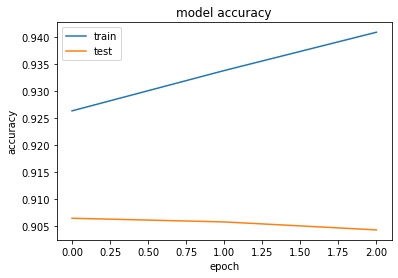

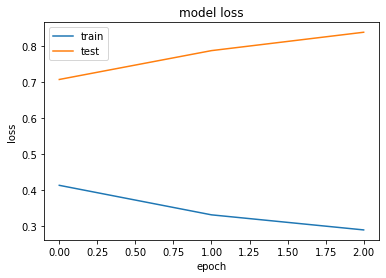

In [14]:
history = r

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

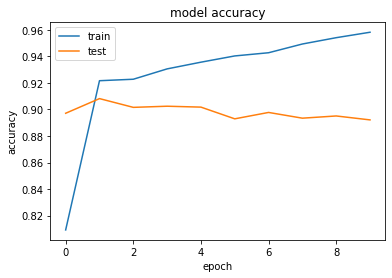

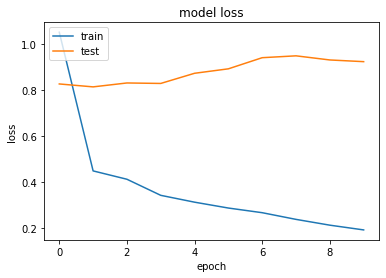

In [15]:
history = r

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('lstm-3-9-2021.h5') 

In [23]:
# '''test'''

# input_sentences=[df.iloc[0]['QA']]
# # 
# # input_sentences=['داخلی رو میگیرم تماس قطع میشه یا بهشون دادید بگید بلافاصله اضافیاشو در فریزر نگهداری کنن و اونی که مصرف می‌کنن در یخچال بذارن و اونی که توی یخچاله دائما از روش مصرف کنن و لایه برداری کن']
# input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
# # print('input_integer_seq',input_integer_seq, input_sentences, [df.iloc[0]['QA']])
# encoder_input_sequences_test = pad_sequences(input_integer_seq, maxlen=max_input_len)

# out = ['<sos>']
# output_input_integer_seq = tokenizer.texts_to_sequences(out)
# decoder_output_sequences_test = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
# # print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
# # print("decoder_input_sequences[172]:", decoder_input_sequences[172])


# print(encoder_input_sequences_test.shape, decoder_output_sequences_test.shape)


# model.predict([encoder_input_sequences_test,decoder_output_sequences_test])

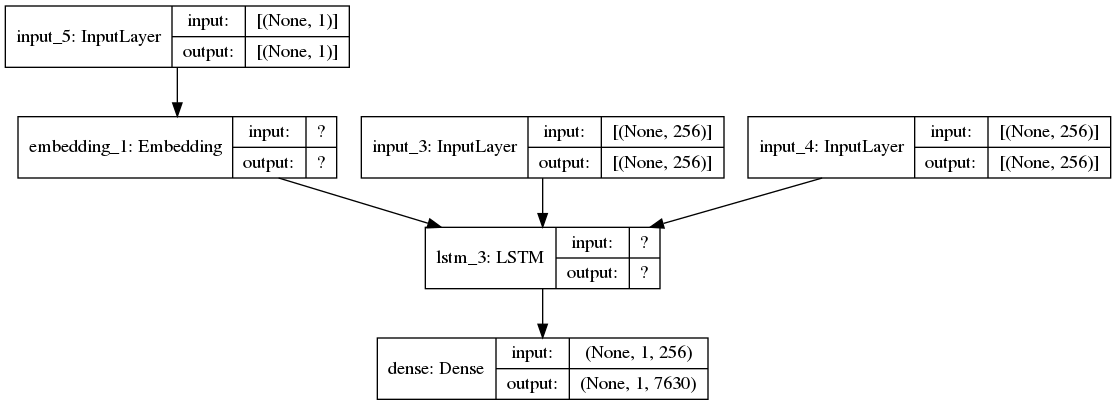

In [16]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


decoder_states = [h, c]
decoder_dense = Dense(num_words, activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [24]:
idx2word_input = {v:k for k, v in word2idx_word.items()}
idx2word_target = {v:k for k, v in word2idx_word.items()}

def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_word['<sos>']
    eos = word2idx_word['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences_test[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

KeyError: '<sos>'

In [17]:
idx2word_input = {v:k for k, v in word2idx_word.items()}
idx2word_target = {v:k for k, v in word2idx_word.items()}

def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
#     target_seq[0, 0] = word2idx_word['<sos>']
    target_seq[0, 0] = -1
#     eos = word2idx_word['<eos>']
    eos = -1
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print(i, '\n-')
print('Input:', input_sentences[i])
print('Response:', translation)

13530 
-
Input: I should buy oreos because oreos s a good snack for during the summer 
Response: ingedients ingedients edgy sell rotor rotor rotor rotor crafty crafty telenor blobs blobs blobs blobs shingles shingles telenor telenor telenor telenor telenor telenor bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists humans hard colora colora colora colora colora colora colora


In [18]:
idx2word_input = {v:k for k, v in word2idx_word.items()}
idx2word_target = {v:k for k, v in word2idx_word.items()}

def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
#     target_seq[0, 0] = word2idx_word['<sos>']
    target_seq[0, 0] = -1
#     eos = word2idx_word['<eos>']
    eos = -1
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print(i, '\n-')
print('Input:', input_sentences[i])
print('Response:', translation)

11013 
-
Input: I should buy a sony walkman phone because it s musical and fun
Response: relation available becausethey becausethey sweepstakes sweepstakes honest detergent detergent detergent detergent becausebecasuse whole whole whole whole spokesperson international international international bmwx bmwx bite park park park park park park park wolf wolf wolf wolf wolf wolf wolf wines wines wines wines wrinkled wrinkled wrinkled wrinkled wrinkled wrinkled plantet international plantet shoulders shoulders shoulders plantet


In [18]:
word2idx_word['island'], len(('ingedients ingedients edgy sell rotor rotor rotor rotor crafty crafty telenor blobs blobs blobs blobs shingles shingles telenor telenor telenor telenor telenor telenor bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists bicyclists humans hard colora colora colora colora colora colora colora'.split(' ')))

(317, 54)